<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/04_5_First_Level_Analysis_Assignment_Help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information which might help you with your assignment

## Plotting of motion parameters

In your assigment, you have to plot motion parameters. This can be done to check the quality of your data.

In [40]:
# Download a motion parameter matrix
!gdown 1GXq5qVOIPwdSaatpF9xGvaElH_kfLJGV

Downloading...
From: https://drive.google.com/uc?id=1GXq5qVOIPwdSaatpF9xGvaElH_kfLJGV
To: /content/sub-01_test_sess1_bold.nii.par
100% 10.7k/10.7k [00:00<00:00, 28.0MB/s]
Archive:  /content/ds000102_tewa.zip
replace /data/ds000102_tewa/raw_data/sub-01/anat/sub-01_T1w.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [41]:
import numpy as np

motion_parameters = np.loadtxt("/content/sub-01_test_sess1_bold.nii.par")
print(f"Shape of motion parameter matrix: {motion_parameters.shape}")
print(motion_parameters[:5, :])

Shape of motion parameter matrix: (146, 6)
[[-0.00392981 -0.00273184 -0.00192909 -0.149195   -0.01741     0.0563946 ]
 [-0.00387436 -0.00273813 -0.00192015 -0.149289    0.00236126  0.101418  ]
 [-0.00391527 -0.00248813 -0.00189263 -0.155317    0.00203427  0.146527  ]
 [-0.00348972 -0.00248813 -0.00176567 -0.165534   -0.00725473  0.12753   ]
 [-0.00331012 -0.00269423 -0.00163729 -0.149341   -0.0261358   0.0917993 ]]


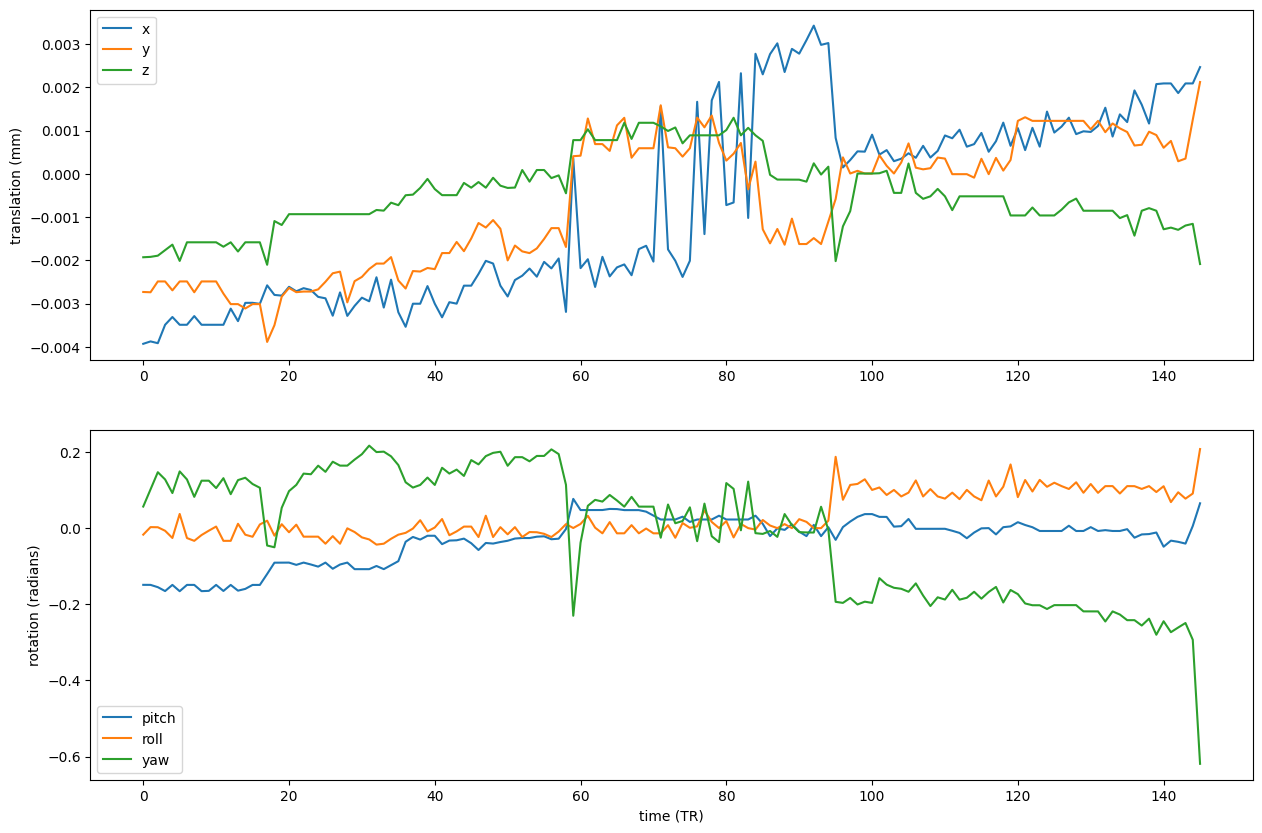

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

axes[0].plot(motion_parameters[:, :3])
axes[1].plot(motion_parameters[:, 3:])

axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x","y","z"])
axes[1].legend(["pitch","roll","yaw"])

How would you assess this: Is there too much movement? Does it look good or bad?

## F-Tests

To potentially help you with your first assignments, we will look at how we can perform an F-test on a single subject. With an F-Test, we can look at whether a certain combination of conditions explains a significant proportion of the neural signal.

### Install dependencies and download data

We will use a dataset from `nilearn.datasets` from an experiment by Geraint Rees. It's purpose was to explore their equipment and try out techniques on their 2T scanner - it was still the early days of fMRI research. Their block design had alternating periods of auditory stimulation and rest. The repetition time can be taken from their [page](https://www.fil.ion.ucl.ac.uk/spm/data/auditory/): TR = 7. The functional data starts at scan number 4.

In [29]:
# install nilearn
!pip install nilearn

# create output directory
!mkdir /output

# Get data from nilearn.datasets
from nilearn.datasets import fetch_spm_auditory
from pprint import pprint

subject_data = fetch_spm_auditory()
pprint(subject_data.func[:5])  # print paths of first 5 func images

mkdir: cannot create directory ‘/output’: File exists
['/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/root/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img']


As you can see, these images are neither in DICOM nor NIfTI format. Also, they are still 3 dimensional. Therefore, we will have to convert them into a 4D format.

In [5]:
from nilearn.image import concat_imgs, mean_img

# converting into 4d image
fmri_img = concat_imgs(subject_data.func)

# creating a mean image
mean_img = mean_img(fmri_img)

In [31]:
# What format are we dealing with now?
type(fmri_img)

nibabel.nifti1.Nifti1Image

In [34]:
data_dir = "/root/nilearn_data/spm_auditory/"
test_subj = "sub001"

### Specifying and Fitting a First-Level Model

First, we look at the .tsv events file to find out which types of trials were included in the experiment. We can use it to create our "events" table which include information we need to fit our data to the model we will create later.

In [35]:
import pandas as pd

events = pd.read_table(f"{data_dir}{test_subj}/fM00223/fM00223_events.tsv")
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


In [8]:
from nilearn.glm.first_level import FirstLevelModel

In [10]:
# Instantiating the model
fmri_glm = FirstLevelModel(
    t_r=7,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

In [11]:
# Fitting the model
fmri_glm = fmri_glm.fit(fmri_img, events)

In [15]:
# Creating a design matrix
design_matrix = fmri_glm.design_matrices_[0]

Now that our model is fitted and we created a design matrix, we can have a look at it:

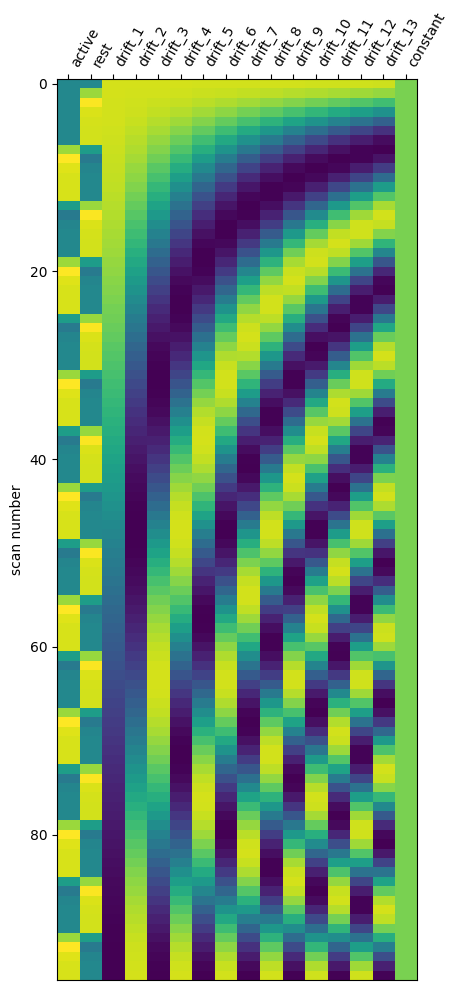

In [16]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix)

plt.show()

## Computing Contrasts

In our F-Test, we want to find out which voxels' activities are explained by the combination of our conditions ("rest" and "active"). Therefore, we first create our contrast matrix, which assigns a weight to each of the predictors of our design-matrix (we have 16 predictors). As we want to look at a combination of the "active" and "rest" condition, we then "stack" them.

In [36]:
import numpy as np

conditions = {"active": np.zeros(16), "rest": np.zeros(16)}
conditions["active"][0] = 1
conditions["rest"][1] = 1
effects_of_interest = np.vstack((conditions["active"], conditions["rest"]))

<Axes: label='conditions'>

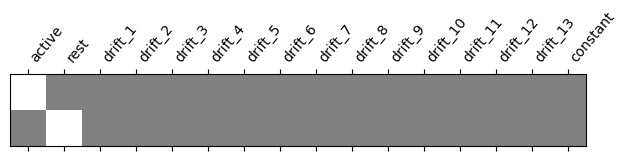

In [37]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(effects_of_interest, design_matrix)

Then, we calculate our contrast map.

In [38]:
z_map = fmri_glm.compute_contrast(effects_of_interest, output_type="z_score")

As you can see, the computation of the contrast works exactly the same as in a t-test.

We can then calculate a threshold for our contrast map. We will do so using the False Discovery Rate (fdr) and setting an arbitrary cluster threshold of 10 - meaning only clusters of 10 voxels and more will be included. Then, we can plot our contrast map using this threshold.

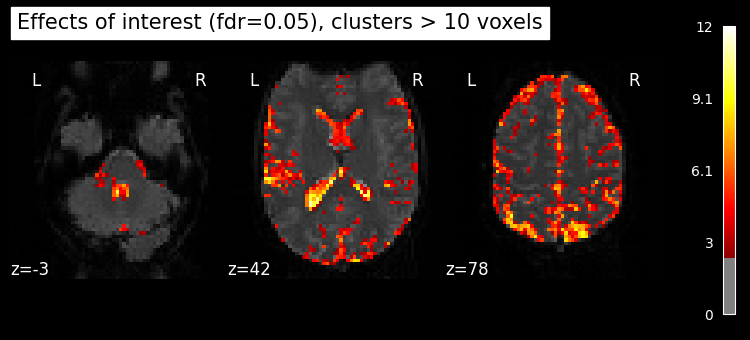

In [27]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map

clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10)


plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

Anything you notice?



